In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2B0, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [2]:
# Images Count
count = 0
dirs = os.listdir('Dataset/')
for dir in dirs:
    files=list(os.listdir('Dataset/'+dir))
    print(dir +' Folder has '+str(len(files)) +' Images ')
    count = count + len(files)
print('Dataset has total of '+str(count) +' Images ')


Mild_H-pylori Folder has 50 Images 
Moderate_H-pylori Folder has 50 Images 
Negative_H-pylori Folder has 50 Images 
Severe_H-pylori Folder has 50 Images 
Dataset has total of 200 Images 


In [3]:
# Load Dataset
base_dir = 'Dataset/'
img_size = 224  # Resize images to fit pre-trained models
batch_size = 32
# epochs = 50

epochs = 10

In [4]:
train_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

val_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

Found 200 files belonging to 4 classes.
Using 160 files for training.
Found 200 files belonging to 4 classes.
Using 40 files for validation.


In [5]:
disease_names = train_ds.class_names
disease_names

['Mild_H-pylori', 'Moderate_H-pylori', 'Negative_H-pylori', 'Severe_H-pylori']

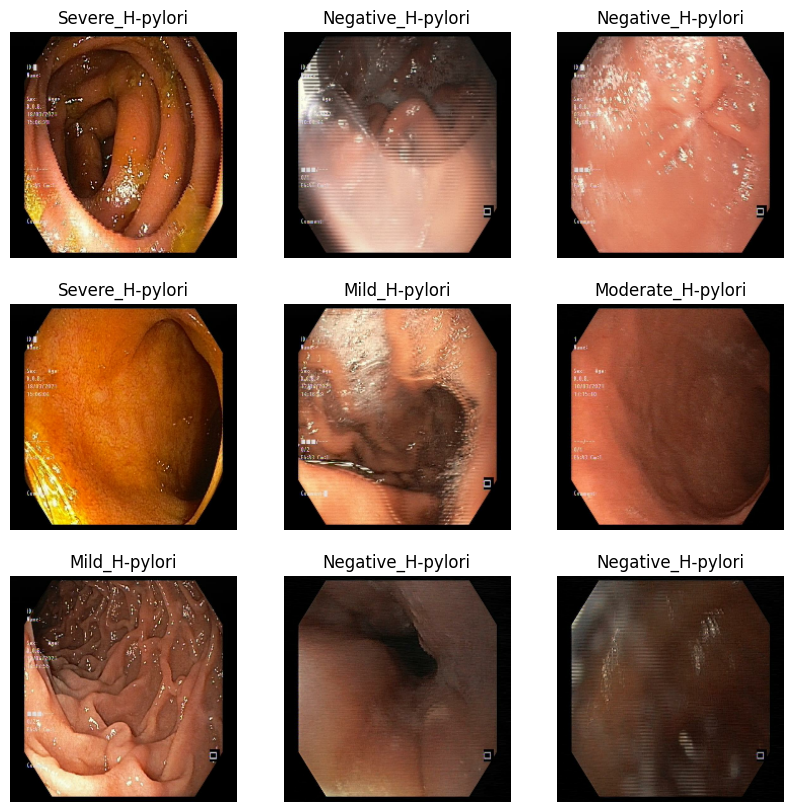

In [6]:
i=0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)                                # display in row x columns
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(disease_names[labels[i]])
        plt.axis('off')                                      #dimension of images

In [7]:
# Advanced Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(factor=0.2),
    layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  # Normalize to [-1, 1]
    layers.experimental.preprocessing.RandomHeight(0.2),
    layers.experimental.preprocessing.RandomWidth(0.2),
    layers.experimental.preprocessing.RandomCrop(img_size, img_size),
])

In [8]:
# Preprocessing Layer
preprocess_layer = layers.Rescaling(1./255)

In [9]:
AUTOTUNE= tf.data.AUTOTUNE #does'nt have to fetch images from dataset one by one, store images in cache

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [11]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

UnknownError: Exception encountered when calling layer "random_crop" "                 f"(type RandomCrop).

Graph execution error:

Detected at node 'loop_body/cond/crop_to_bounding_box/Slice/pfor/mod' defined at (most recent call last):
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PC\AppData\Local\Temp\ipykernel_14892\670531530.py", line 6, in <module>
      images= data_augmentation(images)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 563, in call
      return super().call(inputs, training)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 441, in call
      self._batch_augment(inputs), is_dict, use_targets
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 472, in _batch_augment
      return self._map_fn(self._augment, inputs)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tensorflow\python\ops\parallel_for\control_flow_ops.py", line 198, in f
      warn=warn)
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
    File "C:\Users\PC\anaconda3\envs\hp_env\lib\site-packages\tensorflow\python\ops\parallel_for\pfor.py", line 4472, in f
      [converter._convert_helper(x).t for x in func._func_graph_outputs])
Node: 'loop_body/cond/crop_to_bounding_box/Slice/pfor/mod'
JIT compilation failed.
	 [[{{node loop_body/cond/crop_to_bounding_box/Slice/pfor/mod}}]] [Op:__inference_f_15446]

Call arguments received by layer "random_crop" "                 f"(type RandomCrop):
  • inputs=tf.Tensor(shape=(32, 238, 243, 3), dtype=float32)
  • training=True

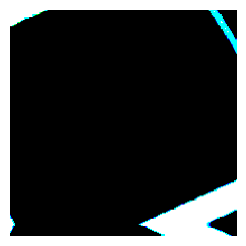

In [11]:
i=0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images= data_augmentation(images)
        plt.subplot(3,3, i+1)                                # display in row x columns
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')                                      #dimension of images

In [12]:
# Attention Mechanism
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer='random_normal', trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        weighted_output = inputs * tf.expand_dims(attention_weights, axis=-1)
        return tf.reduce_sum(weighted_output, axis=1)

In [13]:
# Build EfficientNet Model with Attention
def build_efficientnetv2_with_attention():
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    inputs = Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = AttentionLayer()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(disease_names), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [14]:
# Build ResNet Model with Attention
def build_resnet_with_attention():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    inputs = Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = AttentionLayer()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(disease_names), activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [15]:
# Build InceptionV3 Model
def build_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(len(disease_names), activation='softmax')
    ])

    return model

In [16]:
model.summary()

NameError: name 'model' is not defined

In [17]:
# Compile and Train Models
def compile_and_train(model, train_ds, val_ds):
    model.compile(
        optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)

In [18]:
  history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

  return history

NameError: name 'model' is not defined

In [19]:
# Define and compile models
efficientnet_with_attention = build_efficientnetv2_with_attention()
resnet_with_attention = build_resnet_with_attention()
inceptionv3_model = build_inceptionv3_model()

# Train models
efficientnet_history = compile_and_train(efficientnet_with_attention, train_ds, val_ds)
resnet_history = compile_and_train(resnet_with_attention, train_ds, val_ds)
inceptionv3_history = compile_and_train(inceptionv3_model, train_ds, val_ds)

InvalidArgumentError: Exception encountered when calling layer "attention_layer" (type AttentionLayer).

in user code:

    File "C:\Users\PC\AppData\Local\Temp\ipykernel_14892\3734096804.py", line 14, in call  *
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)

    InvalidArgumentError: `dim` must be in the range [-1, 1) where 1 is the number of dimensions in the input. Received: dim=1


Call arguments received by layer "attention_layer" (type AttentionLayer):
  • inputs=tf.Tensor(shape=(None, 1280), dtype=float32)

In [20]:
# Voting Ensemble
def voting_ensemble_predict(models, dataset):
    predictions = [model.predict(dataset) for model in models]
    summed_predictions = np.sum(predictions, axis=0)
    return np.argmax(summed_predictions, axis=1)

ensemble_models = [efficientnet_with_attention, resnet_with_attention, inceptionv3_model]
val_predictions = voting_ensemble_predict(ensemble_models, val_ds)


NameError: name 'efficientnet_with_attention' is not defined

In [ ]:
# Evaluate Ensemble Model
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_names, yticklabels=disease_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(val_labels, val_predictions, target_names=disease_names))

In [ ]:
model.save('Fyp_CNN_1.h5')